In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import sys
sys.path.append('../utils')
print(sys.path)
import numpy as np
from load_dataset import *
import os

['/home/shiqi/code/Project2-sensor-case/model_combination_Argos/pca_from_formulation', '/home/shiqi/anaconda3/envs/torch/lib/python39.zip', '/home/shiqi/anaconda3/envs/torch/lib/python3.9', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/site-packages', '../utils', '/home/shiqi/code/Project2-sensor-case/model_combination_Argos/utils', '../utils', '../utils', '../utils']


In [29]:
import yaml

config_path = '/home/shiqi/code/Project2-sensor-case/model_combination_Argos/pca_from_formulation/output_hybrid/experiment_3/config.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

In [30]:
save_dir = config['save_dir']

iteration_errors = np.load(os.path.join(save_dir, 'iteration_errors.npy'))

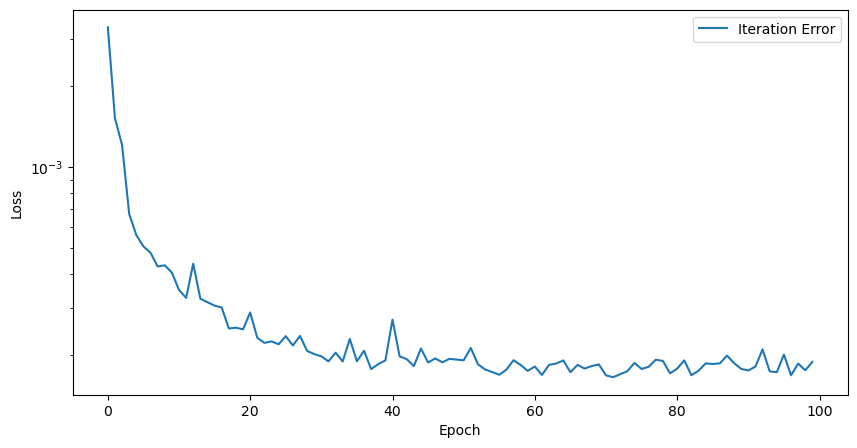

In [31]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(iteration_errors, label='Iteration Error')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [32]:
import torch
import os
import numpy as np
import copy
import pca_koopman_dir as km
from train_model_nonlinear import build_model, SimpleNN, ResidualModel, LinearModel, data_preparation

def initialize_models(config, save_dir):
    # Build the pre-trained model
    pre_trained_model = build_model(config)
    
    # Data preparation
    x_data, y_data, u_data = data_preparation(config, config['fit_data_dir'])
    x_data = torch.tensor(x_data, dtype=torch.float32)
    y_data = torch.tensor(y_data, dtype=torch.float32)
    u_data = torch.tensor(u_data, dtype=torch.float32)
    
    # Compute mean and standard deviation, and create standardization layers
    x_mean = torch.mean(x_data, dim=0)
    x_std = torch.std(x_data, dim=0)
    std_layer_x = km.StdScalerLayer(x_mean, x_std)
    
    u_mean = torch.mean(u_data, dim=0)
    u_std = torch.std(u_data, dim=0)
    std_layer_u = km.StdScalerLayer(u_mean, u_std)
    
    # Load the state dictionary for the linear model
    linear_model_state_dict = torch.load(os.path.join(save_dir, 'linear_model.pth'))
    linear_model = LinearModel(pre_trained_model, std_layer_x, np.zeros(3))
    linear_model.load_state_dict(linear_model_state_dict)
    linear_model.eval()
    
    # Initialize the residual model
    n_features = x_data.shape[1]
    n_inputs = u_data.shape[1]
    residual_NN = SimpleNN(n_features + n_inputs, config['NN_nodes_num'], n_features, config['num_hidden_layers'])
    residual_model = ResidualModel(residual_NN, std_layer_x, std_layer_u, copy.deepcopy(std_layer_x))
    
    # Load the state dictionary for the residual model
    residual_model_state_dict = torch.load(os.path.join(save_dir, 'residual_model.pth'))
    residual_model.load_state_dict(residual_model_state_dict)
    
    return linear_model, residual_model

In [33]:
linear_model, residual_model = initialize_models(config, save_dir)

0
1
2
window_size: 150
(149, 6957) (149, 6957) (149, 2)
x_data shape: (6258, 6957), y_data shape: (6258, 6957), u_data shape: (6258, 2)


In [34]:
from evaluate import load_data, generate_trajectories, calculate_relative_diff, calculate_mean_relative_diff_set, plot_mean_relative_diff
begin, end = 1, 150
window_size = end - begin
nu_list = config['nu_list']
train_data_dir = [config['fit_data_dir']]
x_dataset_train, u_dataset_train, nu_dataset_train = load_data(begin, end, train_data_dir, nu_list)

0


In [35]:
def generate_trajectories_hybrid(x_dataset, u_dataset, linear_model, residual_model, device = 'cpu'):
    # Generate the trajectories using the hybrid model
    linear_model = linear_model.to(device)
    residual_model = residual_model.to(device)
    linear_model.eval()
    residual_model.eval()
    x_data_pred_traj = []
    window_size = len(x_dataset[0])
    for x_data, u_data in zip(x_dataset, u_dataset):
        steps = window_size

        x_data = torch.tensor(x_data, dtype=torch.float32).to(device)
        u_data = torch.tensor(u_data, dtype=torch.float32).to(device)
        x_pred = torch.zeros_like(x_data).to(device)
        x_pred[0, :] = x_data[0, :]

        for i in range(1, steps):
            x_pred[i, :] = linear_model(x_pred[i-1:i, :], u_data[i-1:i, :]) + residual_model(x_pred[i-1:i, :], u_data[i-1:i, :])
        
        x_data_pred_traj.append(x_pred.cpu().detach().numpy())
    return x_data_pred_traj

In [36]:
x_data_pred_traj_train = generate_trajectories_hybrid(x_dataset_train, u_dataset_train, linear_model, residual_model)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


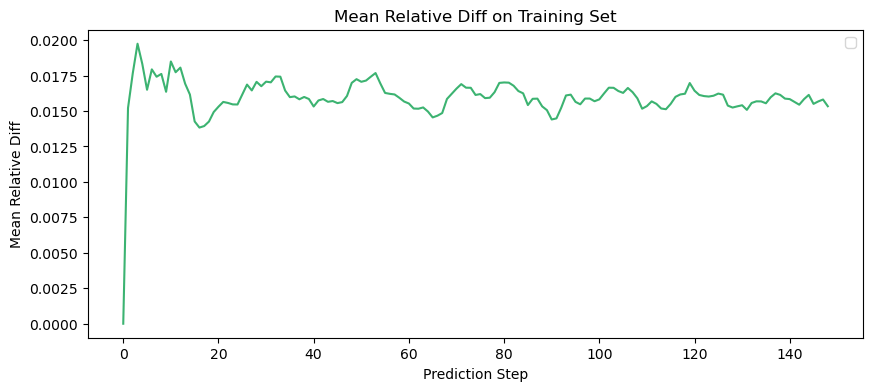

In [37]:
plot_mean_relative_diff(x_dataset_train, x_data_pred_traj_train)

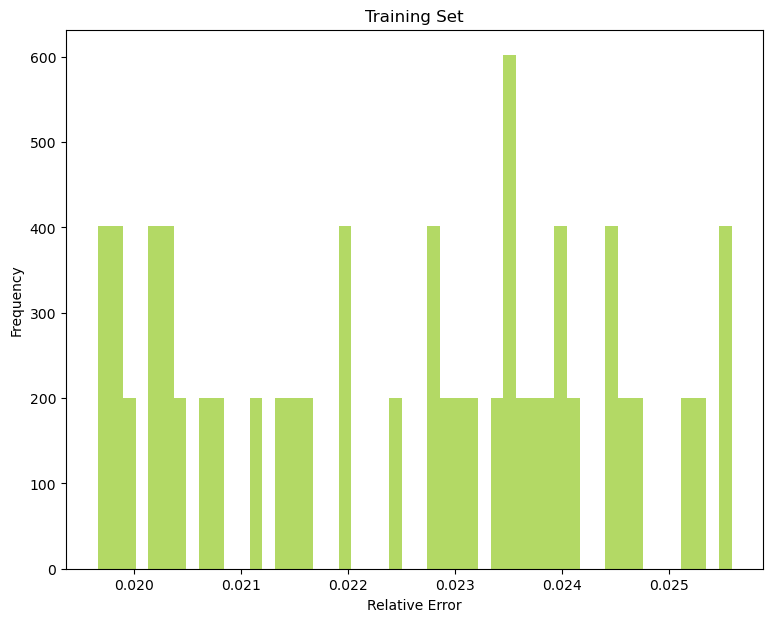

In [38]:
from evaluate import plot_relative_error
plot_relative_error(x_dataset_train, x_data_pred_traj_train)

In [39]:
len(x_dataset_train)

42